In [1]:
#import some useful packages
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
from skimage import img_as_ubyte
from IPython.display import HTML

In [2]:
#camera_calibration
#get the parameters of cameraCalibration
def get_calibration_parameters(chessboardname, nx, ny):
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    images = glob.glob(chessboardname)
    ret_count = 0
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = (img.shape[1], img.shape[0])
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            ret_count += 1
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return ret, mtx, dist, rvecs, tvecs

#undistort images    
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

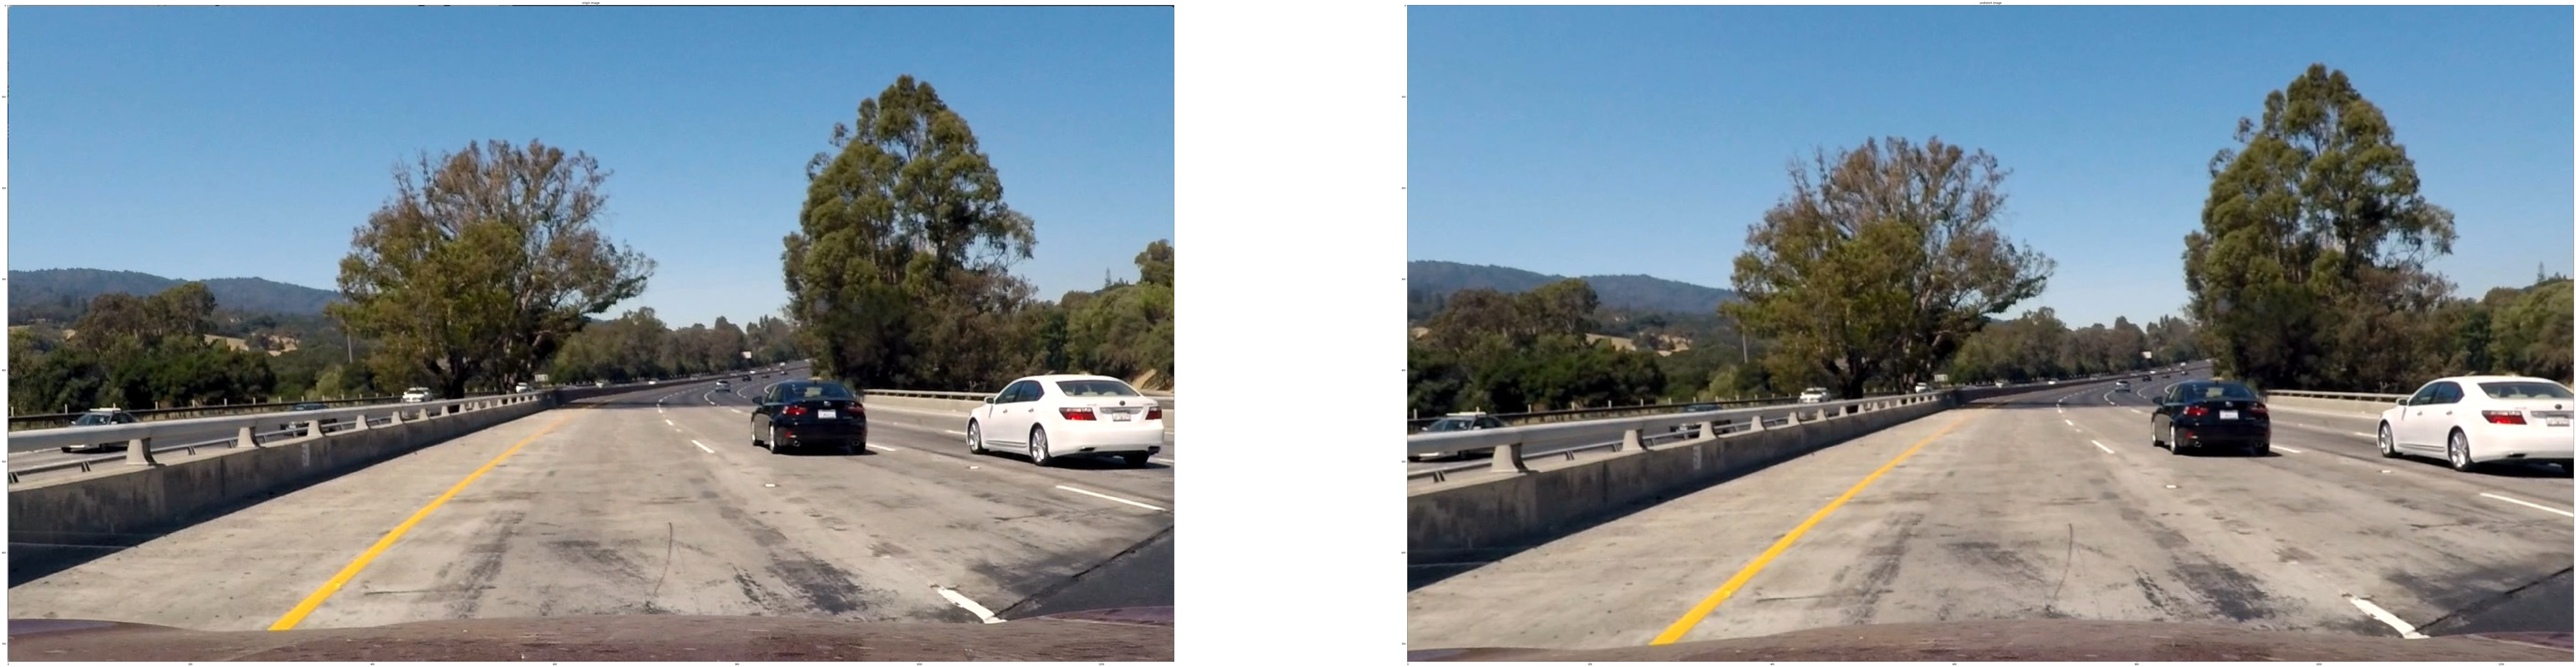

True

In [3]:
#test for calibration
nx = 9
ny = 6
ret, mtx, dist, rvecs, tvecs = get_calibration_parameters('camera_cal/calibration*.jpg', nx, ny)
#path = './camera_cal/calibration1.jpg'
path = './test_images/test1.jpg'

img = cv2.imread(path)
undist = undistort(img, mtx, dist)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (200,200))
plt.subplot(1, 2, 1)
plt.title('origin image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('undistort image')
plt.imshow(undist)
plt.show()

#cv2.imwrite('./output_images/calibration_example.jpg', undist)
cv2.imwrite('./output_images/calibration1.jpg', undist)

In [4]:
#find the roughly area of lane
def find_area(path):
    image = cv2.imread(path)
    cv2.circle(image, left_up, 0, (0, 0, 255), 10)
    cv2.circle(image, right_up, 0, (0, 0, 255), 10)
    cv2.circle(image, left_down, 0, (0, 0, 255), 10)
    cv2.circle(image, right_down, 0, (0, 0, 255), 10)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

    #Perspective Transformation    
def perspective_transform(image):
    img_h = image.shape[0]
    img_w = image.shape[1]
    src = np.float32([left_up, left_down, right_up, right_down])
    dst = np.float32([[200, 0], [200, 680], [1000, 0], [1000, 680]])
    #transform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (img_w, img_h), flags=cv2.INTER_NEAREST)
    return warped, M



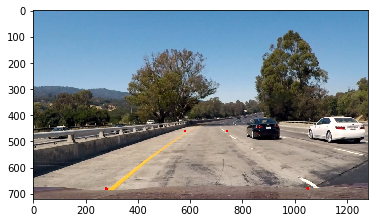

True

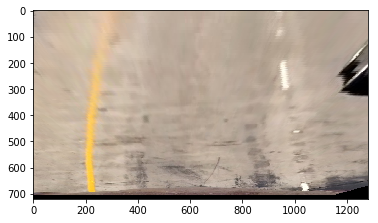

In [5]:
#test for perspective transformation
#choose 4 points to prepare for transformation
left_up = (580, 460)
right_up = (740, 460)
left_down = (280, 680)
right_down = (1050, 680)

find_area(path)
warped, M = perspective_transform(undist)
plt.imshow(warped)
cv2.imwrite('./output_images/perspective_example.jpg', warped)

In [6]:
#find the edges of lanes
def edge_detection(image, sobel_kernel=3, sc_threshold=(110, 255), sx_threshold=(20, 100)):
    img = np.copy(image)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #transform the images into HSV images
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:, :, 0]
    l_channel = hsv[:, :, 1]
    s_channel = hsv[:, :, 2]
    channel = s_channel
    #use S channel to do edge and color detection
    #combine these two methods to get binary images
    sobel_x = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    scaled_sobel_x = cv2.convertScaleAbs(255*sobel_x/np.max(sobel_x))
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= sx_threshold[0]) & (scaled_sobel_x <= sx_threshold[1])] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(channel >= sc_threshold[0]) & (channel<=sc_threshold[1])]=1
    com_binary = np.zeros_like(sx_binary)
    com_binary[(sx_binary == 1) | (s_binary == 1)] = 1
    return com_binary


True

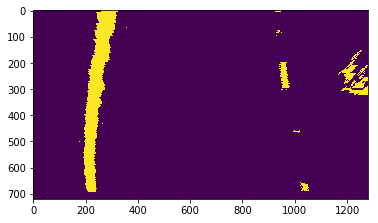

In [7]:
#test for binary output image
binary_img = edge_detection(warped)
plt.imshow(binary_img)
cv2.imwrite('./output_images/binary_example.jpg', binary_img)

In [8]:
#find the region of interest(ROI)
def roi(img,points=[(120, 710),(280, 0), (1100, 0), (1050,710)]):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255, )*channel_count
    else:
        ignore_mask_color = 255
    
    vertices = np.array([points], dtype = np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [22]:
#find the lanes
def color_compare():
    image, M = perspective_transform()
    canny_image = dege_detection(image)

def plot_hist(image, axis=0):
    histogram = np.sum(image[image.shape[0]/2:, :], axis)

def find_lines(roi_image):
    histogram = np.sum(roi_image[int(roi_image.shape[0]/2):, :],axis=0)
    out_image = np.dstack((roi_image, roi_image, roi_image)) * 255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(roi_image.shape[0]/nwindows)
    nonzero = roi_image.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 80
    minpix = 50

    left_lane_indices = []
    right_lane_indices = []

    for window in range(nwindows):
        win_y_low = roi_image.shape[0] - (window + 1) * window_height
        win_y_high = roi_image.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        fit_left_indices = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]        
        fit_right_indices = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_indices.append(fit_left_indices)
        right_lane_indices.append(fit_right_indices)

        if len(fit_left_indices) > minpix:
            leftx_current = np.int(np.mean(nonzerox[fit_left_indices]))
        if len(fit_right_indices) > minpix:
            rightx_current = np.int(np.mean(nonzerox[fit_right_indices]))
    
    
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
    
    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices]
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices]

    if righty.size == 0 or rightx.size == 0:
        righty = lefty
        rightx = leftx
    elif lefty.size == 0 or leftx.size == 0:
        lefty = righty
        leftx = rightx
    
    ploty = np.linspace(0, roi_image.shape[0]-1, roi_image.shape[0])

    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    out_image[nonzeroy[left_lane_indices], nonzerox[left_lane_indices]] = [255,0,0]
    out_image[nonzeroy[right_lane_indices], nonzerox[right_lane_indices]] = [0,0,255]
    
    ym_per_pix = 20/roi_image.shape[1]
    xm_per_pix = 3.5/roi_image.shape[0]
    y_eval = np.max(ploty) 
    
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    m_car = roi_image.shape[1]/2  
    m_lane = (left_fitx[-1] + right_fitx[-1])/2
    offset_right_from_center_m = (m_lane - m_car)*xm_per_pix
    avg_radius_meters = np.mean([left_curverad, right_curverad])

    return out_image, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty
    



In [10]:
#draw the lines on the origin images
def to_real_scale(original, out_image, M, left_fitx, right_fitx, ploty):
    color_warp = np.zeros_like(out_image).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (original.shape[1], original.shape[0]))
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    return result

def draw_lanes(original, out_image, M, left_fitx, right_fitx, ploty):
    color_warp = np.zeros_like(out_image).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    lane = cv2.addWeighted(original, 1, color_warp, 0.3, 0)
    return lane

def process_image(image):
    undistort_image = undistort(image, mtx, dist)
    transform_image, M = perspective_transform(undistort_image)
    edge_image = edge_detection(transform_image)
    roi_image = roi(edge_image)
    out_image, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty = find_lines(roi_image)
    
    global old_image_lines
    global l_fit_buffer
    global r_fit_buffer

    if old_image_lines is None:
        old_image_lines = roi_image

    ret = cv2.matchShapes(old_image_lines, roi_image, 1, 0.0)
    if ret < 50:
        old_image_lines = roi_image
        if l_fit_buffer is None:
            l_fit_buffer = np.array([left_fitx])

        if r_fit_buffer is None: 
            r_fit_buffer = np.array([right_fitx])

        l_fit_buffer = np.append(l_fit_buffer, [left_fitx], axis=0)[-20:]
        r_fit_buffer = np.append(r_fit_buffer, [right_fitx], axis=0)[-20:]

    l_fit_mean = np.mean(l_fit_buffer, axis=0)
    r_fit_mean = np.mean(r_fit_buffer, axis=0)
    after_process_image = to_real_scale(image, out_image, M, l_fit_mean, r_fit_mean, ploty)
    cv2.putText(after_process_image, 'Radius of curvature:'+str(round(avg_radius_meters))+'m', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=2)
    cv2.putText(after_process_image, 'Vehicle is'+str(round(offset_right_from_center_m, 3))+'m right of center', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    
    return after_process_image





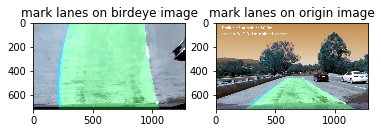

In [19]:
def show_lanes():
    image = cv2.imread('./test_images/test1.jpg')
    transform_image, M = perspective_transform(image)
    edge_image = edge_detection(transform_image)
    roi_image = roi(edge_image)
    out_image, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty = find_lines(roi_image)
    mark_lanes_on_birdeye = draw_lanes(transform_image, out_image, M, left_fitx, right_fitx, ploty)
    mark_lanes_on_origin = to_real_scale(image, out_image, M, left_fitx, right_fitx, ploty)
    
    cv2.putText(mark_lanes_on_origin, 'Radius of curvature:'+str(round(avg_radius_meters))+'m', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=2)
    cv2.putText(mark_lanes_on_origin, 'Vehicle is'+str(round(offset_right_from_center_m, 3))+'m right of center', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(mark_lanes_on_birdeye)
    ax1.set_title('mark lanes on birdeye image')
    ax2.imshow(mark_lanes_on_origin)
    ax2.set_title('mark lanes on origin image')
    plt.show()
    cv2.imwrite('./output_images/draw_lanes_example1.jpg', mark_lanes_on_birdeye)
    cv2.imwrite('./output_images/draw_lanes_example2.jpg', mark_lanes_on_origin)

#test for drawing lanes
old_image_lines = None
l_fit_buffer = None
r_fit_buffer = None
show_lanes()

In [23]:
#try in the video
output_video = './output_video.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(output_video, audio = False)

[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


100%|█████████▉| 1260/1261 [04:27<00:00,  4.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 



In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [25]:
output_challenge_video = './output_challenge_video.mp4'
clip2 = VideoFileClip('./challenge_video.mp4')
white_clip2 = clip2.fl_image(process_image)
white_clip2.write_videofile(output_challenge_video, audio = False)

[MoviePy] >>>> Building video ./output_challenge_video.mp4
[MoviePy] Writing video ./output_challenge_video.mp4


100%|██████████| 485/485 [01:40<00:00,  5.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_challenge_video.mp4 



In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_challenge_video))

In [27]:
output_harder_challenge_video = './output_harder_challenge_video.mp4'
clip3 = VideoFileClip('./harder_challenge_video.mp4')
white_clip3 = clip3.fl_image(process_image)
white_clip3.write_videofile(output_harder_challenge_video, audio = False)

[MoviePy] >>>> Building video ./output_harder_challenge_video.mp4
[MoviePy] Writing video ./output_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [05:00<00:00,  4.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_harder_challenge_video.mp4 



In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_harder_challenge_video))